In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import re

from functools import reduce

from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import pairwise_distances

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestNeighbors

from sklearn.utils import resample
from sklearn.base import clone

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

!pip install pymorphy2
import pymorphy2

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20,10)

In [0]:
def make_merged_docs(groups, titles):
  dct = {}
  for (doc_id, title) in zip(titles.doc_id, titles.title):
    dct[doc_id] = title
  titles_to_merge = []
  for doc_id in groups.doc_id:
    if doc_id in dct:
      titles_to_merge.append(dct[doc_id])
    else:
      titles_to_merge.append('')
  docs_merged = groups.copy()
  docs_merged["title"] = pd.Series(titles_to_merge)
  return docs_merged

In [0]:
def draw_tsne(docs_merged, vectorizer):
  y = docs_merged.target

  for (i, group) in enumerate([39, 4, 100, 14, 48, 63]):
    X_embedded = TSNE(
        n_components=2,
        metric='cosine'
        ).fit_transform(
        vectorizer.transform(
            docs_merged[docs_merged.group_id == group].title
            ).toarray(),
        )
    plt.subplot(2, 3, i + 1)
    plt.scatter(X_embedded[::, 0], X_embedded[::, 1],
                c=y[docs_merged.group_id == group])
  plt.show()

In [0]:
class MyFoldGenerator:
  def __init__(self, groups, n_splits=1, cv=None):
    self.__n_splits = n_splits
    self.__groups = groups
    if cv is not None:
      self.__cv = cv
    else:
      self.__cv = LeavePGroupsOut(self.__n_splits) 
  def split(self, X, y, *args):
    yield from self.__cv.split(X, y, self.__groups)
  def get_n_splits(self, X, y, *args):
    return self.__cv.get_n_splits(X, y, self.__groups)

In [0]:
def cross_validation(
    model, X, y, groups, cv=None,
    score_func=f1_score, treshold=None, 
    use_tqdm=True
    ):
  score = 0
  if cv is None:
    cv = LeavePGroupsOut(1)
  seq = cv.split(X, y, groups)
  if use_tqdm:
    seq = tqdm(list(seq))
  count = 0
  for (train, test) in seq:
    model.fit(X[train], y[train])
    if treshold is not None:
      score += score_func(
          y[test], model.predict(X[test]) > treshold
          ) * y[test].shape[0]
    else:
      score += score_func(
          y[test], model.predict(X[test])
          ) * y[test].shape[0]
    count += 1
  return score / y.shape[0]

In [0]:
morph = pymorphy2.MorphAnalyzer()

In [0]:
def lemmatize_titles(pattern, titles):
  titles = list(map(
      lambda title: re.findall(pattern, title.lower()),
      titles)
  )
  lemmed_titles = []
  all_words = set()
  for title in titles:
    lemmed_title = []
    for word in title:
      all_words.add(word)
      lemmed_title.append(morph.parse(word)[0].normal_form)
    lemmed_titles.append(lemmed_title)
  titles = np.asarray(list(map(" ".join, lemmed_titles)))
  return titles

In [0]:
def draw_arms(docs_merged, vectorizer):
  for (i, group_id) in enumerate([39, 4, 100, 14, 48, 63]):
    plt.subplot(2, 3, i + 1)
    neigh = NearestNeighbors(n_neighbors=2)
    X = vectorizer.transform(
            docs_merged.title[docs_merged.group_id == group_id]
        )
    X = TSNE(n_components=2, metric='cosine').fit_transform(X.toarray())
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    distances /= np.max(distances)
    plt.plot(distances)
  plt.show()

In [0]:
class BootstrapClassifier:
  def __init__(self, model, n_divisions=10 ,n_estimators=50):
    self.__model = model
    self.__n_estimators = n_estimators
    self.__n_divisions = n_divisions
    self.__estimators = None
  
  def fit(self, X, y):
    estimators = []
    for _ in range(self.__n_estimators):
      x_est, y_est = resample(
      X, y, stratify=y, n_samples=int(y.shape[0] / self.__n_divisions)
      )
      try:
        clf_est = clone(self.__model)
      except:
        clf_est = self.__model.clone()
      clf_est.fit(x_est, y_est)
      estimators.append(clf_est)
    self.__estimators = estimators

  def predict(self, X):
    return np.apply_along_axis(
        lambda i: self.__estimators[i[0]].predict(X),
        -1,
        np.arange(self.__n_estimators, dtype=int)[::, np.newaxis]
        ).sum(axis=0) >= self.__n_estimators / 2.0

In [0]:
class ClassifierFromReg:
  def __init__(self, model, trs):
    self.__model = model
    self.__treshold = trs
  
  def fit(self, X, y):
    self.__model.fit(X, y)

  def predict(self, X):
    return self.__model.predict(X) > self.__treshold

  def clone(self):
    return ClassifierFromReg(clone(self.__model), self.__treshold)


In [0]:
class LinRegClassifier:
  def __init__(self, alpha=None, treshold=None):
    self.__model = Ridge(alpha=alpha)
    self.__treshold = treshold
    self.__alpha = alpha

  def fit(self, X, y, **fit_params):
    if "alpha" in fit_params and "treshold" in fit_params:
      self.set_params(fit_params["alpha"], fit_params["treshold"])
    self.__model.fit(X, y)
    return self

  def predict(self, X):
    return self.__model.predict(X) > self.__treshold

  def set_params(self, alpha, treshold):
    self.__model = Ridge(alpha=alpha)
    self.__treshold = treshold
    self.__alpha = alpha
    return self

  def get_params(self, *args, **kwargs):
    return {"alpha": self.__alpha, "treshold": self.__treshold}
  
  def clone(self):
    return LinRegClassifier(self.__alpha, self.__treshold)

In [0]:
def make_features(groups, vectorizer, titles, docs_merged):
  groups_indixes = groups.group_id.unique()
  X_train = []

  for group_id in groups_indixes:
    group_x = vectorizer.transform(
        titles[docs_merged.group_id == group_id]
    )
    features = np.sort(np.asarray(
        pairwise_distances(group_x, metric='cosine')
        ))[::,1:11:]
    features2 = np.sort(
        KMeans(n_clusters=8, random_state=0).fit_transform(features)
    )
    clusters = AgglomerativeClustering(
        affinity="precomputed", linkage="complete"
        ).fit_predict(pairwise_distances(group_x, metric='cosine')
    )

    values, counts = np.unique(clusters, return_counts=True)
    features3 = clusters == values[np.argmax(counts)]
    X_train.append(np.hstack((features, features2))) #, features3[::, np.newaxis])))
  X_train = np.vstack(X_train)
  X_train = StandardScaler().fit_transform(X_train)
  return X_train

In [0]:
def make_feature0(X):
  neigh = NearestNeighbors(n_neighbors=2)
  eps = 0.5
  nbrs = neigh.fit(X)
  distances, indices = nbrs.kneighbors(X)
  dist = np.max(distances[:,1])
  m = DBSCAN(eps=eps * dist, min_samples=5)
  m.fit(X)
  clusters = m.labels_
  labels = np.unique(clusters)
  result = np.zeros((X.shape[0],), dtype=float)
  for name in labels:
    result[clusters == name] = np.asarray(
        pairwise_distances(X[clusters == name])
        ).mean() / dist
  return result[::, np.newaxis]


def make_features_experimental(groups, vectorizer, titles, docs_merged):
  groups_indixes = groups.group_id.unique()
  X_train = []

  for group_id in groups_indixes:
    group_x = vectorizer.transform(
        titles[docs_merged.group_id == group_id]
    )
    x_emb = TSNE(
        n_components=2, metric='cosine'
        ).fit_transform(group_x.toarray())
    features0 = make_feature0(x_emb)

    features = np.sort(np.asarray(
        pairwise_distances(group_x, metric='cosine')
        ))[::,1:11:]
    features2 = np.sort(
        KMeans(n_clusters=8, random_state=0).fit_transform(features)
    )
    clusters = AgglomerativeClustering(
        affinity="precomputed", linkage="complete"
        ).fit_predict(pairwise_distances(group_x, metric='cosine')
    )

    values, counts = np.unique(clusters, return_counts=True)
    features3 = clusters == values[np.argmax(counts)]
    X_train.append(np.hstack((features, features2, features0, 
                              features3[::, np.newaxis])))
  X_train = np.vstack(X_train)
  X_train = StandardScaler().fit_transform(X_train)
  return X_train

In [0]:
titles = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/docs_titles.tsv",
     sep="\t"
     )
groups = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/train_groups.csv",
     sep=","
     )

In [0]:
pattern = re.compile(
    (r'[a-z]+\-?[a-z]*\.[a-z]{2}|[а-я]+\-?[а-я]*\.[а-я]{2}|'
    '[а-я]+\-?[а-я]*|[a-z]+\-?[a-z]*|[0-9]+')
)

In [0]:
titles_lemmed = lemmatize_titles(pattern, titles.title.fillna(""))
titles["title"] = pd.Series(titles_lemmed)
titles

,doc_id,title
0,15731,ваза 21213 замена подшипник ступица нива
1,14829,ваза 2107 оптом в сочи сравнить цена купить по...
2,15764,купить ступица лада калин 2 трансмиссия перехо...
3,17669,классика 21010 21074
4,14852,ступица нива замена подшипник свой рука
...,...,...
27945,16637,ответ mail.ru полезно ли кушать творог по утро...
27946,16759,творог полезный свойство и лечение творог женс...
27947,15358,творог полезный и опасный свойство творог
27948,17287,ответ mail.ru чем полезный творог


In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), token_pattern=pattern)
vectorizer.fit(titles.title)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False,
                token_pattern=re.compile('[a-z]+\\-?[a-z]*\\.[a-z]{2}|[а-я]+\\-?[а-я]*\\.[а-я]{2}|[а-я]+\\-?[а-я]*|[a-z]+\\-?[a-z]*|[0-9]+'),
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
docs_merged = make_merged_docs(groups, titles)
docs_merged.head()

,pair_id,group_id,doc_id,target,title
0,1,1,15731,0,ваза 21213 замена подшипник ступица нива
1,2,1,14829,0,ваза 2107 оптом в сочи сравнить цена купить по...
2,3,1,15764,0,купить ступица лада калин 2 трансмиссия перехо...
3,4,1,17669,0,классика 21010 21074
4,5,1,14852,0,ступица нива замена подшипник свой рука


In [0]:
X_train = make_features_experimental(groups, vectorizer, docs_merged.title, docs_merged)

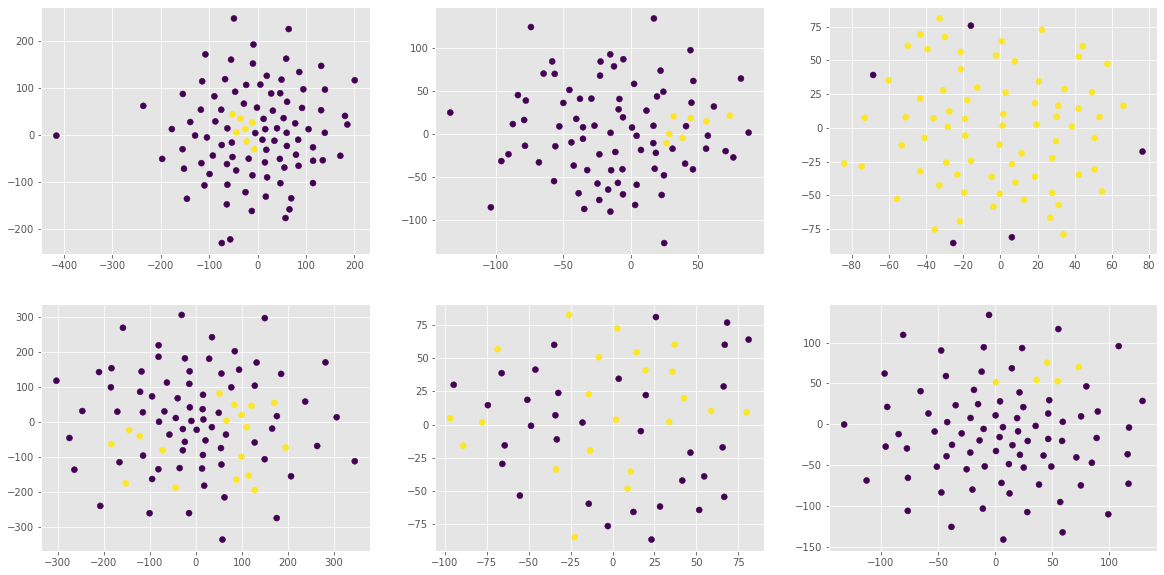

In [0]:
draw_tsne(docs_merged, vectorizer)

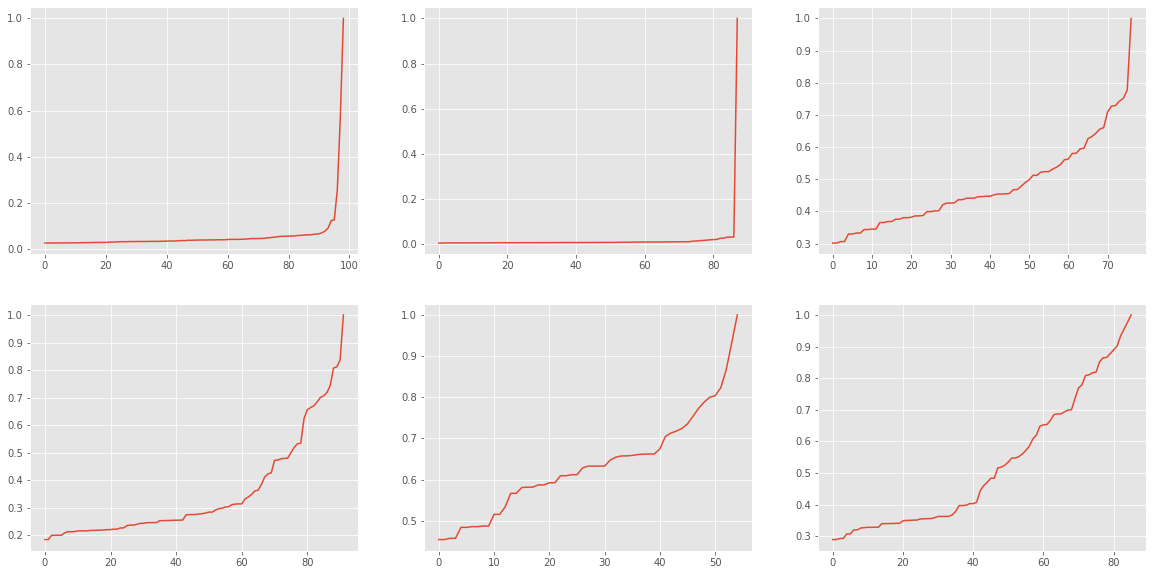

In [0]:
draw_arms(docs_merged, vectorizer)

In [0]:
y = docs_merged.target

In [0]:
cv = MyFoldGenerator(groups=docs_merged.group_id, cv=GroupKFold(10))

In [0]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": np.arange(2, 10, dtype=int),
    "max_features": [None, "sqrt", "log2"]
}

model = GridSearchCV(
    RandomForestClassifier(n_estimators=30), param_grid=param_grid, cv=cv,
    scoring='f1', n_jobs=-1
    ).fit(X_train, y)

In [0]:
clf_forest = model.best_estimator_
cross_validation(
    clf_forest, X_train[::, ::], 
    y, docs_merged.group_id,
    cv, f1_score, treshold=0.5, use_tqdm=False
    )

0.7099973382517619

In [0]:
importances = model.best_estimator_.feature_importances_[np.newaxis, ::]
X_train = X_train[::, ::] * importances
# importances = model.best_estimator_.feature_importances_
# X_train = X_train[::, importances.argsort()[::-1][:15:]]

In [0]:
param_grid = {
    "alpha": np.logspace(0.1, 10, 100),
    "treshold": np.linspace(0, 0.35, 35) 
}
model = GridSearchCV(
    LinRegClassifier(), param_grid=param_grid, cv=cv,
    scoring='f1', n_jobs=-1
    ).fit(X_train, y)
clf_reg = model.best_estimator_
cross_validation(
    clf_reg, X_train[::, ::], 
    y, docs_merged.group_id,
    cv, f1_score, treshold=0.5, use_tqdm=False
    )

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7139826177120786

In [0]:
clf_reg.get_params()

{'alpha': 15.848931924611142, 'treshold': 0.23676470588235293}

In [0]:
clf_forest.feature_importances_.argsort()

array([19, 10,  1,  0, 13, 12, 17, 16, 18, 11, 14, 15,  8,  9,  2,  7,  5,
        6,  3,  4])

In [0]:
groups_test = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/test_groups.csv",
     sep=","
     )

In [0]:
docs_merged_test = make_merged_docs(groups_test, titles)

In [0]:
X_test = make_features_experimental(
    groups_test, vectorizer, docs_merged_test.title, docs_merged_test
    ) * importances

In [0]:
pred = np.asarray(clf_reg.predict(X_test), dtype=int)

In [0]:
groups_test["target"] = pd.Series(pred)
with open("predict.csv", "w") as f:
  f.write(groups_test.to_csv(columns=("pair_id", "target"), index=False))